### To Do: 

- mlp introspectors
- coeff error logging


In [1]:
# ==== Imports ====

# essential libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# standard libraries
import os, tempfile
from pathlib import Path
from collections import OrderedDict

# feature_library stuff
from __future__ import annotations
from dataclasses import dataclass
from typing import Callable, Dict, List, Optional, Tuple, Iterable, Set, Union


In [2]:
# ==== Device Selection ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [31]:
# === MLPs ===

class Sin(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class SimpleMLP(nn.Module):
    def __init__(self, n_layers, hidden_size):
        super(SimpleMLP, self).__init__()
        assert n_layers >= 2, "n_layers must be at least 2"

        layers = []
        # First layer: input (2,) -> hidden_size
        layers.append(nn.Linear(2, hidden_size))
        layers.append(Sin())

        # Hidden layers: (m -> m)
        for _ in range(n_layers - 2):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(Sin())

        # Final layer: (m -> 1)
        layers.append(nn.Linear(hidden_size, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, t, x):
        input_tensor = torch.cat((t, x), dim=1)  # Concatenate along feature axis
        return self.model(input_tensor)

#class symMLP(nn.Module):
#    def __init__(self, input_size, n_layers, hidden_size, linear_only=False, bias=False):
#        super(symMLP, self).__init__()
#        assert n_layers >= 1, "n_layers must be at least 1"
#
#        layers = []
#        if n_layers == 1:
#            # Direct input -> output
#            layers.append(nn.Linear(input_size, 1, bias=bias))
#        else:
#            # First layer: input -> hidden
#            layers.append(nn.Linear(input_size, hidden_size))
#            if not linear_only:
#                layers.append(nn.ReLU())
#            # Intermediate layers
#            for _ in range(n_layers - 2):
#                layers.append(nn.Linear(hidden_size, hidden_size))
#                if not linear_only:
#                    layers.append(nn.ReLU())
#            # Final layer
#            layers.append(nn.Linear(hidden_size, 1))
#
#        self.model = nn.Sequential(*layers)
#
#    def forward(self, x):   
#        return self.model(x)
    
class symMLP(nn.Module):
    """
    Readout-only baseline, EQL-swappable contract.

    v(F) = readout([F, 1])

    - Keeps readout shape (K+1 -> 1), bias=False
    - Does NOT use any other weights in forward
    - Keeps preop_ns/postop_ns for inspection, but they are dummy/constant
    """
    def __init__(self, in_dim: int, prod_dim: int = 2, bias: bool = False):
        super().__init__()

        self.readout = nn.Linear(in_dim, 1, bias=False)

    def forward(self, feats: torch.Tensor) -> torch.Tensor:
        Y = torch.cat([feats], dim=1)  # (N, K+1)
        return self.readout(Y)              # (N, 1)

    

In [4]:
# === Feature Library ===

@dataclass
class FeatureTensorOut:
    F: torch.Tensor                  # (B,K) normalized if normalize=True
    names: List[str]                 # length K
    scales: torch.Tensor             # (K,) detached; 1.0 if not normalized
    raw_cols: Optional[torch.Tensor] = None  # (B,K) raw (unnormalized) if keep_raw=True

class FeatureTensor:
    """
    Builds feature columns: "u", "u_x", "u_xx", ...
    Any requested non-primitive terms are ignored (with a warning).

    Expects u_out shape (B,1) and x tensor (B,1) with requires_grad=True
    when derivative terms are requested. Returns F shaped (B,K).
    """

    def __init__(
        self,
        terms: Iterable[str],
        normalize: bool = True,
        eps: float = 1e-12,
        keep_raw: bool = False,
    ) -> None:
        self.terms = list(terms)
        self.normalize = bool(normalize)
        self.eps = float(eps)
        self.keep_raw = bool(keep_raw)

        # runtime artifacts
        self.names: List[str] = []
        self.scales: Optional[torch.Tensor] = None  # (K,)

    def _l2_detached(self, col: torch.Tensor) -> torch.Tensor:
        # scalar (detached)
        return col.detach().reshape(-1).norm(p=2).clamp_min(self.eps)

    def _grad1(self, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return torch.autograd.grad(
            y, x, grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True
        )[0]

    def build(
        self,
        u_out: torch.Tensor,
        *,
        t: Optional[torch.Tensor] = None,
        x: Optional[torch.Tensor] = None,
        y: Optional[torch.Tensor] = None,
    ) -> FeatureTensorOut:
        _ = (t, y)  # explicit ignore (keeps signature stable)

        allowed = {"u", "u_x", "u_xx", "uu_x"}
        requested = [s for s in self.terms if s in allowed]
        ignored = [s for s in self.terms if s not in allowed]
        if ignored:
            print(f"Ignoring non-primitive terms: {ignored} [c:FeatureTensor]")

        if not requested:
            raise RuntimeError(f"No primitive features requested (allowed: {sorted(allowed)})")

        need = set(requested)

        feats: List[torch.Tensor] = []       # list of (B,1) normalized columns
        raw_list: List[torch.Tensor] = []    # list of (B,1) raw columns if keep_raw
        names: List[str] = []
        scales_list: List[torch.Tensor] = [] # list of scalar tensors (detached)

        def add(name: str, raw: torch.Tensor, normalize_col: bool = True) -> None:
            raw_ = raw[:, None] if raw.ndim == 1 else raw
            if raw_.ndim != 2 or raw_.shape[1] != 1:
                raise ValueError(f"Feature '{name}' must be (B,1); got {tuple(raw_.shape)}")

            if self.normalize and normalize_col:
                s = self._l2_detached(raw_)     # scalar
                col = raw_ / s
            else:
                s = torch.tensor(1.0, device=raw_.device, dtype=raw_.dtype)
                col = raw_

            feats.append(col)
            names.append(name)
            scales_list.append(s.detach())

            if self.keep_raw:
                raw_list.append(raw_)

        # Cache derivatives
        if ("u_x" in need or "u_xx" in need or "uu_x" in need) and x is None:
            raise ValueError("Requested x-derivative feature but x is None.")

        u_x = u_xx = uu_x = None
        if "u_x" in need or "u_xx" in need:
            u_x = self._grad1(u_out, x)
        if "u_xx" in need:
            u_xx = self._grad1(u_x, x)
        if "uu_x" in need:
            uu_x = u_out * u_x
            
        # Build primitives
        if "u" in need:
            add("u", u_out, normalize_col=True)
        if "u_x" in need:
            add("u_x", u_x, normalize_col=True)
        if "u_xx" in need:
            add("u_xx", u_xx, normalize_col=True)
        if "uu_x" in need: 
            add("uu_x", uu_x, normalize_col=True)
        if not feats:
            raise RuntimeError("No features produced. Check 'terms' and provided coords.")

        F = torch.cat(feats, dim=1)  # (B,K)
        scales = torch.stack(scales_list).reshape(-1).detach()  # (K,)

        raw_cols = torch.cat(raw_list, dim=1) if self.keep_raw else None  # (B,K) or None

        # save artifacts
        self.names = names
        self.scales = scales

        return FeatureTensorOut(F=F, names=names, scales=scales, raw_cols=raw_cols)

        

In [5]:
# === EQL ===

class EQL(nn.Module):
    def __init__(self, in_dim, prod_dim=2, bias=False):
        """
        in_dim: number of input features (e.g. u, ux, uxx)

        prod_dim: number of linear combinations to create for pairwise products
        """
        super().__init__()
        self.linear = nn.Linear(in_dim, prod_dim, bias=bias)
        self.readout = nn.Linear(in_dim + 1, 1, bias=False)


    def forward(self, feats):
        Z = self.linear(feats)  # (N, prod_dim)
        self.preop_ns = Z  # save for inspection
        prod_neuron = torch.prod(Z, dim=1, keepdim=True)  # (N,1)
        self.postop_ns = prod_neuron  # save for inspection
        Y = torch.cat([feats, prod_neuron], dim=1)        # (N, in_dim+1)
        return self.readout(Y)


In [ ]:
eql_example = EQL(in_dim=3, prod_dim=2)
print(eql_example)
lay1_matrix = eql_example.linear.weight.data
readout_matrix = eql_example.readout.weight.data
print("EQL linear layer weights:")
print(lay1_matrix)
print("EQL readout layer weights:")
print(readout_matrix)

some_input = torch.randn(5, 3)  # (N=5, in_dim=3)
output = eql_example(some_input)
print("Input to EQL:")
print(some_input)
in_to_prod = eql_example.linear(some_input)  # (5, prod_dim=2)
prod_neuron = torch.prod(in_to_prod, dim=1, keepdim=True)

print("Intermediate product neuron value:")
print(prod_neuron)
print("Proof that output is correct:")
print("Output = readout_matrix @ [feats, prod_neuron]")
print("Let's verify this manually:")
manual_output = readout_matrix @ torch.cat([some_input, prod_neuron], dim=1).T
print(manual_output)
print("Are they equal?")
print(torch.allclose(output.T, manual_output))

EQL(
  (linear): Linear(in_features=3, out_features=2, bias=True)
  (readout): Linear(in_features=4, out_features=1, bias=False)
)
EQL linear layer weights:
tensor([[ 0.5416,  0.2811,  0.4971],
        [-0.4266, -0.0862,  0.1026]])
EQL readout layer weights:
tensor([[ 0.1164,  0.3778, -0.4674,  0.1188]])
Input to EQL:
tensor([[ 0.4980, -1.5086, -0.5090],
        [ 0.6901,  0.8990,  2.0549],
        [ 0.7697, -2.0203, -0.3845],
        [-0.3627, -0.1875, -0.5289],
        [ 1.0318, -1.5971, -1.4358]])
Intermediate product neuron value:
tensor([[ 0.1666],
        [-1.2722],
        [ 0.1331],
        [ 0.1493],
        [ 0.4391]], grad_fn=<ProdBackward1>)
Proof that output is correct:
Output = readout_matrix @ [feats, prod_neuron]
Let's verify this manually:
tensor([[-0.2543, -0.6917, -0.4782,  0.1519,  0.2400]], grad_fn=<MmBackward0>)
Are they equal?
True


In [6]:
#def extract_symbolic_pde_deep(trainer):
#    """
#    Symbolic PDE extractor. If v is linear or a stack of Linear, multiply weights.
#    Uses trainer.feature_names/powers captured during the latest step.
#    """
#    layers = [layer for layer in trainer.v.model if isinstance(layer, nn.Linear)]
#    assert len(layers) >= 1, "No linear layers found in symMLP"
#
#    # Effective weight from input features to scalar output
#    W = layers[0].weight.detach().cpu().numpy()
#    for layer in layers[1:]:
#        W = layer.weight.detach().cpu().numpy() @ W
#    W = W.flatten()  # [n_features]
#
#    a_hat = float(pt.exp(trainer.log_a).detach().cpu())
#
#    terms = []
#    for coef, name, p in zip(W, trainer.feature_names, trainer.feature_powers):
#        terms.append(f"{(a_hat**p)*coef:.6f} · {name}")
#
#    print(f"Learned scale a = {a_hat:.6f}")
#    print("Reconstructed PDE:")
#    print("    u_t ≈ " + " + ".join(terms))

In [7]:
# ==== PDE Extractor ====

def extract_symbolic_pde_deep(
    trainer,
    show_raw=True,
    show_physical=True,
    library_scales_attr=("feature_scales", "feature_powers"),  # you currently return "powers" but it is scales
    eps=1e-12
):
    """
    Extract effective linear map v(F) = w^T F where F is the library fed into v. 
    F includes constant term so bias is not needed in v net itself. 

    Supports current library normalization:
        F_i = raw_i / scale_i   where scale_i = ||raw_i|| (detached)
    Then:
        v(F) = Σ w_i * (raw_i / scale_i) + b
      => coeff on raw_i is w_raw_i = w_i / scale_i

    Input: 
    """

    # ---------- 1) Compose Linear stack ----------

    layers = trainer.v.model
    if isinstance(layers, nn.Module) and not hasattr(layers, "__iter__"):
        layers = [layers]

    W_eff = None
    for m in layers:
        if isinstance(m, nn.Linear):
            W = m.weight.detach().cpu()              # [out_dim, in_dim]
            if W_eff is None:
                W_eff = W.clone()
            else:
                W_eff = W @ W_eff
        elif isinstance(m, (nn.ReLU, nn.Tanh, nn.Sigmoid, nn.GELU, nn.SiLU, nn.LeakyReLU, nn.ELU)):
            raise ValueError("Nonlinear activation in v; linear coefficient extraction is invalid.")
        else:
            raise ValueError(f"Unhandled layer in v: {type(m).__name__}")

    if W_eff is None:
        raise ValueError("No nn.Linear layers found in trainer.v.model.")

    if W_eff.shape[0] != 1:
        raise ValueError(f"v outputs {W_eff.shape[0]} dims; expected 1.")

    w = W_eff.reshape(-1).numpy()                      # [n_features]

    names = getattr(trainer, "feature_names", [f"f{i}" for i in range(len(w))])

    # ---------- 3) Undo your library column normalization (raw features) ----------
    scales = None
    if library_scales_attr is not None:
        if isinstance(library_scales_attr, (tuple, list)):
            for attr in library_scales_attr:
                if hasattr(trainer, attr):
                    scales = getattr(trainer, attr)
                    if scales is not None:
                        break
        else:
            scales = getattr(trainer, library_scales_attr, None)
            print(f'library_scales_attr is {library_scales_attr}, scales is {scales}')

    if scales is not None:
        if torch.is_tensor(scales):
            s = scales.detach().cpu().numpy().reshape(-1)
        else:
            s = np.asarray(scales).reshape(-1)

        if len(s) != len(w):
            raise ValueError(f"Scale length {len(s)} != n_features {len(w)}")

        s = np.clip(s, eps, None)
        w_raw = w / s
    else:
        # Must make sure scales are provided in trainer
        w_raw = w

    # ---------- printing ----------
    print("\nCoefficients on F (features fed into v have already been normalized by their scales):")
    for wi, nm in zip(w, names):
        print(f"  {wi:+.6f} · {nm}")

    if show_raw:
        print("\nCoefficients on raw library terms (undoing per-column ||raw|| normalization):")
        for wi, nm in zip(w_raw, names):
            print(f"  {wi:+.6f} · {nm}")
    b=0.0
    return w_raw, b, names


def extract_eql(trainer, eps=1e-12, print_out=True):
    eql = trainer.v

    if not (isinstance(eql.linear, nn.Linear) and isinstance(eql.readout, nn.Linear)):
        raise TypeError("trainer.v is not EQL-like (expected .linear and .readout as nn.Linear).")

    K = eql.linear.in_features
    p = eql.linear.out_features  # prod_dim

    # readout expects K+1 inputs: [F, prod]
    if eql.readout.weight.shape != (1, K + 1):
        raise ValueError(f"readout weight shape should be (1,{K+1}); got {tuple(eql.readout.weight.shape)}")

    names = getattr(trainer, "feature_names", [f"f{i}" for i in range(K)])
    if len(names) != K:
        raise ValueError(f"feature_names length {len(names)} != in_dim {K}")

    scales = getattr(trainer, "feature_scales", None)
    if scales is None:
        raise ValueError("trainer.feature_scales missing; store ft.scales during step().")
    s = scales.detach().cpu().numpy().reshape(-1)
    if len(s) != K:
        raise ValueError(f"feature_scales length {len(s)} != in_dim {K}")
    s = np.clip(s, eps, None)

    # Parameters
    A = eql.linear.weight.detach().cpu().numpy()   # (p, K)
    b = eql.linear.bias.detach().cpu().numpy()     # (p,)
    w_all = eql.readout.weight.detach().cpu().numpy().reshape(-1)  # (K+1,)
    w_F = w_all[:K]                                # linear coeffs on normalized F
    w_P = float(w_all[K])                          # coeff on product neuron

    # Undo per-column normalization for the linear part
    w_F_raw = w_F / s

    if print_out:
        print("\nEQL structure:")
        print("  v(F) = Σ_i w_i F_i  +  wP * PROD(F)")
        print("  PROD(F) = Π_j Zj(F),   Z(F) = A F + b")
        print("  (your library uses F_i = raw_i / scale_i)\n")

        print("Linear readout on normalized features F:")
        for wi, nm in zip(w_F, names):
            print(f"  {wi:+.6f} · {nm}")
        print(f"  {w_P:+.6f} · PROD\n")

        print("Linear readout on raw features (undo scaling):")
        for wi, nm in zip(w_F_raw, names):
            print(f"  {wi:+.6f} · {nm}")
        print(f"  {w_P:+.6f} · PROD  (note: PROD still uses normalized F unless expanded)\n")

        print("Product neuron factors:")
        for j in range(p):
            parts = []
            for i in range(K):
                a = A[j, i]
                if abs(a) > 0:
                    parts.append(f"{a:+.4g}·{names[i]}")
            inner = " ".join(parts) if parts else "0"
            print(f"  Z{j}(F) = {b[j]:+.4g}  {inner}")
        print("  PROD(F) = Π_j Zj(F)")

    return {
        "names": names,
        "scales": s,
        "A": A,
        "b": b,
        "w_F": w_F,
        "w_F_raw": w_F_raw,
        "w_P": w_P,
    }


In [42]:
# === Trainer ===
def _soft_thresh(x, lam):
    # elementwise soft-threshold
    return torch.sign(x) * torch.clamp(torch.abs(x) - lam, min=0.0)

def heatmap(matrix):
    # Column correlation heatmap for A
    corr = np.corrcoef(matrix, rowvar=False)
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_xticks(np.arange(corr.shape[0])); ax.set_yticks(np.arange(corr.shape[0]))
    ax.set_xticklabels([f"col{i}" for i in range(corr.shape[0])])
    ax.set_yticklabels([f"col{i}" for i in range(corr.shape[0])])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            ax.text(j, i, f"{corr[i, j]:.2f}", ha="center", va="center", color="black")
    ax.set_title("Column correlation heatmap of A")
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

class PDETrainerNonlinear:
    def __init__(self, u_config, v_config, lr=1e-3, lambda_pde=1.0, lambda_reg=1e-3, lambda_tv=1e-4, lambda_data=1.0, v_type=EQL, selected_derivs=(), device=device, true_pde=None):
        self.device = device
        self.u = SimpleMLP(**u_config).to(self.device)
        self.v = v_type(**v_config).to(self.device)
        #self.v = symMLP(**v_config).to(self.device)
        self.lambda_pde = lambda_pde
        self.lambda_reg = lambda_reg
        self.lambda_data = lambda_data
        self.selected_derivs = list(selected_derivs)
        self.lambda_tv = lambda_tv
        params = list(self.u.parameters()) + list(self.v.parameters())
        self.optimizer = optim.Adam(params, lr=lr)
        self.mse = nn.MSELoss()
        self.true_pde = true_pde
        self.feature_tensor = FeatureTensor(terms=selected_derivs, normalize=True)

    def _grad_norm_module(self, module):
        total = 0.0
        for p in module.parameters():
            if p.grad is not None:
                total += p.grad.pow(2).mean()
        if total == 0.0:
            return 0.0
        return float(total.sqrt().item())

    def _build_features(self, u_out, x=None, y=None, terms=None, eps=1e-12):
        """
        Build library matrix F with per-feature norm normalization.

        New contract:
        - F_i = raw_i / scale_i
        - scales[i] = ||raw_i||_2  (detached scalar, >= eps)
        - Return: F [batch, n_feat], names [list[str]], scales [list[float or tensor]]
        """
        if terms is None:
            raise RuntimeError("No terms provided ~ _build_features requires 'terms' argument")

        feats, names, scales = [], [], []

        def Lp_norm_detached(t: torch.Tensor, pth=2) -> torch.Tensor:
            # scalar Lp norm over all entries
            return t.detach().reshape(-1).norm(p=pth).clamp_min(eps)

        def add(name: str, raw: torch.Tensor, normalize: bool = True, scale_override: torch.Tensor | None = None):
            if raw is None:
                return
            if normalize:
                s = scale_override if scale_override is not None else Lp_norm_detached(raw, pth=2)
                col = raw / s
            else:
                s = torch.tensor(1.0, device=raw.device, dtype=raw.dtype)
                col = raw
            feats.append(col)
            names.append(name)
            scales.append(s)

        need = set(terms)

        # ---- cache derivatives to avoid recomputation ----
        u_x = u_xx = u_y = u_yy = None

        if x is not None and ({"u_x","2u_x","u_xx","u_x_x","u_x_xx","uu_x","2uu_x"} & need):
            u_x = torch.autograd.grad(u_out, x, grad_outputs=torch.ones_like(u_out), create_graph=True)[0]

        if x is not None and ({"u_xx","u_x_xx"} & need):
            u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        if y is not None and ({"u_y","u_yy"} & need):
            u_y = torch.autograd.grad(u_out, y, grad_outputs=torch.ones_like(u_out), create_graph=True)[0]

        if y is not None and ("u_yy" in need):
            u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

        # ---- build raw features ----
        if "u" in need and x is not None:
            add("u", u_out, normalize=True)

        if "u_x" in need and x is not None:
            add("u_x", u_x, normalize=True)

        if "2u_x" in need and x is not None:
            raw = 2 * u_x
            add("2u_x", raw, normalize=True)

        if "u_xx" in need and x is not None:
            add("u_xx", u_xx, normalize=True)

        if y is not None and "u_y" in need:
            raw = u_y
            add("u_y", raw, normalize=True)

        if y is not None and "u_yy" in need:
            raw = u_yy
            add("u_yy", raw, normalize=True)

        if "uu" in need:
            add("uu", u_out * u_out, normalize=True)

        if "u_x_x" in need and x is not None:
            add("u_x_x", u_x * u_x, normalize=True)

        if "u_x_xx" in need and x is not None:
            add("u_x_xx", u_x * u_xx, normalize=True)

        if "uu_x" in need and x is not None:
            add("uu_x", u_out * u_x, normalize=True)

        if "c" in need:
            add("c", torch.ones_like(u_out), normalize=False)

        F = torch.cat(feats, dim=1) if feats else None
        if F is not None and F.device != self.device:
            F = F.to(self.device)

        return F, names, scales  

    def _pdenet_get(self):
        """
        For EQL:
          Z = A F + b
          PROD = Π_j Z_j
          v(F) = sum_i w_F[i] * F_i + w_P * PROD
        where F are the normalized library columns built by FeatureTensor.
        """
        mlp = self.v
        # names/scales from last feature build
        names = getattr(self, "feature_names", None)
        scales = getattr(self, "feature_scales", None)
        if names is None or scales is None:
            raise RuntimeError("feature_names/feature_scales not set. Store ft.names/ft.scales on the trainer during step().")

        if isinstance(mlp, EQL):
            w_readout = mlp.readout.weight.detach().cpu().numpy()  # (K+1,)
            w_inprod = mlp.linear.weight.detach().cpu().numpy()
        elif isinstance(mlp, symMLP):
            w_readout = mlp.readout.weight.detach().cpu().numpy()  # (K+1,)
            w_inprod = None  # symMLP doesn't have a fixed product structure
        return names, scales.detach().cpu().numpy(), w_readout, w_inprod

    def _pde_truth(self, u_out, x=None, y=None): 
        '''
        ex: 
        true_pde = {
            'u_xx': 0.02, 
            'uu_x': -1.0, 
        }
        F_true = dict_to_tensor(true_pde)
        _pde_truth is dict_to_tensor
        expected output (using _pde_truth) so that u_t - F_true@F works: 
        '''

        terms = list(self.true_pde.keys())
        coeffs = torch.tensor([self.true_pde[t] for t in terms], device=self.device, dtype=torch.float32).view(-1, 1)
        F_true, _, __ = self._build_features(u_out, x=x, y=y, terms=terms)
        if F_true is None:
            raise RuntimeError("No features were produced; check provided term library (reminder: _build_feats(terms=...))")
        
        RHS = F_true @ coeffs  # [B, 1]

        return RHS

    def set_lrs(self, lr_u=None, lr_v=None, lr_a=None):
    # param_groups: 0=u, 1=v, 2=a
        if lr_u is not None: self.optimizer.param_groups[0]["lr"] = lr_u
        if lr_v is not None: self.optimizer.param_groups[1]["lr"] = lr_v
        if lr_a is not None: self.optimizer.param_groups[2]["lr"] = lr_a

    def set_lambdas(self, lambda_pde=None, lambda_reg=None, lambda_a=None, lambda_tv=None, lambda_data=None):
        if lambda_pde is not None: self.lambda_pde = lambda_pde
        if lambda_reg is not None: self.lambda_reg = lambda_reg
        if lambda_a is not None:   self.lambda_a   = lambda_a
        if lambda_tv is not None:  self.lambda_tv  = lambda_tv
        if lambda_data is not None:self.lambda_data= lambda_data

    def tv1d_space(self, u_fn, t, x, eps=1e-6, reduce="mean"):
        """
        Smoothed TV  in space:  E[ sqrt(u_x^2 + eps^2) ]
        u_fn : callable(t, x) -> u  (N,1)
        t,x  : (N,1) tensors with requires_grad as needed
        eps  : Charbonnier smoothing (avoid nondifferentiability at 0)
        reduce : "mean" | "sum" | None  (returns tensor if None)
        """
        u = u_fn(t, x)
        ones = torch.ones_like(u)
        ux = torch.autograd.grad(u, x, grad_outputs=ones,
                                 create_graph=True, retain_graph=True)[0]
        tv = torch.sqrt(ux**2 + eps**2)
        if reduce == "mean":  return tv.mean()
        if reduce == "sum":   return tv.sum()
        return tv

    def step(self, t, x, u_data, u_data_clean, coeff_plot=False, target=[], tv_type="u"):
        # processing
        t = t.to(self.device)
        x = x.to(self.device)
        u_data = u_data.to(self.device)
        u_data_clean = u_data_clean.to(self.device)
        t.requires_grad_(True)
        x.requires_grad_(True)
        u_out = self.u(t, x)
        loss = torch.tensor(0.0, device=self.device)
        loss_data = self.mse(u_out, u_data)

        #F, names, powers = self._build_features(u_out, x=x, y=None, terms=self.selected_derivs)
        self.ft = self.feature_tensor.build(u_out, x=x)
        
        F, self.feature_names, self.feature_scales = self.ft.F, self.ft.names, self.ft.scales

        #assert F.shape[1] == self.v.linear.in_features, f"Feature dim mismatch: F has {F.shape[1]} cols but EQL expects {self.v.linear.in_features}"

        #print(f'shape of F is {F.shape}')
        #print(f'names is {names}\n powers is {powers}')

        u_t = torch.autograd.grad(u_out, t, grad_outputs=torch.ones_like(u_out), create_graph=True)[0]
        u_x = torch.autograd.grad(u_out, x, grad_outputs=torch.ones_like(u_out), create_graph=True)[0]
        self.u_time=u_t
        pred_true_data = self.mse(u_out, u_data_clean)
        #pred_true_resid = self.mse(u_t, self._pde_truth(u_out, x=x, y=None) if self.true_pde is not None else torch.tensor(0.0, device=self.device))
        pred_true_resid = torch.tensor([1.0])
        v_out = self.v(F)
        if tv_type == "u":
            L_tv = self.tv1d_space(self.u, t, x, eps=1e-6, reduce="mean")
        else: 
            L_tv = self.tv1d_space(u_x, t, x, eps=1e-6, reduce="mean")

        loss_pde = self.mse(u_t, v_out)
        #print(u_t.shape, v_out.shape, F.shape)
        l1 = sum(p.abs().sum() for p in self.v.parameters())

        loss += self.lambda_data * loss_data
        loss += self.lambda_pde * loss_pde
        loss += self.lambda_reg * l1
        loss += self.lambda_tv * L_tv

        self.optimizer.zero_grad()
        loss.backward()

        r = (u_t - v_out).squeeze(1)      # (N,)
        alignment = F.T @ r               # (K,)

        theta_norms = torch.norm(F, dim=0) # (K,)
        residual_norm = torch.norm(r)          # scalar
        grad_pred = -2 * alignment

        grad_u = self._grad_norm_module(self.u)
        grad_v = self.v.parameters().__next__().grad.clone()

        self.optimizer.step()
        coeff_error = None
        if coeff_plot:
            assert target is not None, "No target coeff provided"
            # extract current physical coefficients
            names, scales, A, b, w_RO, w_IP, bias = self._pdenet_get()
            curr_co = list(map(float, w_RO)) + [float(bias)]     # list[float]
            target  = list(map(float, target))
            assert len(curr_co) == len(target), "target length must match learned coeff length"
            coeff_error = np.abs(np.array(curr_co, dtype=np.float64) -
                                 np.array(target,  dtype=np.float64))  # shape [n_terms]

        return {
            "total_loss": float(loss.item()),
            "data_loss":  float(loss_data.item()),
            "pde_loss":   float(loss_pde.item()),
            "l1_penalty": float(l1.item()),
            "tv_denoise": float(L_tv.item()),
            "pred_true_data": float(pred_true_data.item()),
            "pred_true_resid": float(pred_true_resid.item()),
            
            "grad_u": grad_u,
            "grad_v": grad_v,

            "coeff_error": coeff_error,   # None or np.ndarray [n_terms]
            "coeff_names": names if coeff_plot else None,

            "grad_pred": grad_pred.detach().cpu().numpy(),  # (K,)
            "theta_norms": theta_norms.detach().cpu().numpy(),  # (K,)
            "residual_norm": float(residual_norm.item())
        }

    def train(self, epochs, batch_fn, log_every=100, coef_gt=None, coeff_plot=False, t_dom=None, x_dom=None, y_dom=None, batch_size=1024):
            lt, ld, lp, ll, ltv, pt_data, pt_resid, = [], [], [], [], [], [], []
            coeff_err_hist = []   # list of np.ndarray [n_terms] per epoch
            coeff_names_ref = None
            grad_u_hist, grad_v_hist = [], []
            grad_pred_hist, theta_norms_hist, residual_norm_hist = [], [], []


            for epoch in range(epochs):
                t, x, u_noisy, u_clean = batch_fn(batch_size=batch_size, t_torch=t_dom, x_torch=x_dom, y_torch=y_dom)
                losses = self.step(t, x, u_noisy, u_clean,
                                   target=coef_gt, coeff_plot=coeff_plot, tv_type="u")
                lt.append(losses["total_loss"])
                ld.append(losses["data_loss"])
                lp.append(losses["pde_loss"])
                ll.append(losses["l1_penalty"])
                ltv.append(losses["tv_denoise"])
                pt_data.append(losses["pred_true_data"])
                pt_resid.append(losses["pred_true_resid"])
                grad_u_hist.append(losses["grad_u"])
                grad_v_hist.append(losses["grad_v"])
                grad_pred_hist.append(losses["grad_pred"])
                theta_norms_hist.append(losses["theta_norms"])
                residual_norm_hist.append(losses["residual_norm"])

                if coeff_plot and (losses["coeff_error"] is not None):
                    if coeff_names_ref is None and losses.get("coeff_names") is not None:
                        coeff_names_ref = list(losses["coeff_names"]) + ["bias"]
                    coeff_err_hist.append(losses["coeff_error"])

                if epoch % log_every == 0 or epoch == epochs - 1:
                    print(f"Epoch {epoch}: total={lt[-1]:.4e}, data={ld[-1]:.4e}, pde={lp[-1]:.4e}, l1={ll[-1]:.4e}, ltv={ltv[-1]:.4e}, pt_resid={pt_resid[-1]:.4e}, pt_data={pt_data[-1]:.4e}")
                    names, scales, w_RO, w_IP = self._pdenet_get()
                    
                    print("Input to Product Neurons")
                    print(w_IP)

                    print("Readout Tensor Array")
                    print(w_RO)   


            # Turn coeff_err_hist into an array [epochs, n_terms] if collected
            coeff_err_hist = (np.vstack(coeff_err_hist) if coeff_err_hist else None)

            return lt, ld, lp, ll, ltv, pt_resid, pt_data, grad_u_hist, grad_v_hist, coeff_err_hist, coeff_names_ref, grad_pred_hist, theta_norms_hist, residual_norm_hist


In [30]:
isinstance(trainer_nl.v, symMLP)

True

In [10]:
# Burgers solver (NumPy, CPU)
# ==============================
@dataclass
class BurgersConfig:
    N: int       # grid points
    L: float     # domain length
    nu: float    # viscosity
    dt: float    # time step
    T: float     # final time
    seed: int    # random seed for ICs and noise

def solve_burgers(cfg: BurgersConfig, return_history: bool = False):
    """
    1D viscous Burgers' equation on [0, L) with periodic BCs:
        u_t + u * u_x = nu * u_xx

    Space: 2nd-order centered differences for u_x and u_xx.
    Time: 4th-order Runge–Kutta (explicit).
    """
    rng = np.random.default_rng(cfg.seed)
    N, L, nu, dt, T = cfg.N, cfg.L, cfg.nu, cfg.dt, cfg.T

    # Grid
    x = np.linspace(0.0, L, N, endpoint=False)
    dx = L / N

    # Random Gaussian bump ICs, periodic-aware distance; zero-mean
    centers = rng.uniform(0.0, L, size=5)
    heights = rng.uniform(0.5, 2.0, size=5)
    widths  = rng.uniform(0.05*L, 0.25*L, size=5)
    u = np.zeros_like(x)
    for c, a, s in zip(centers, heights, widths):
        dx_wrap = np.minimum(np.abs(x - c), L - np.abs(x - c))
        u += a * np.exp(-0.5 * (dx_wrap / s)**2)
    u -= np.mean(u)

    # Periodic centered differences
    def dudx(u):
        return (np.roll(u, -1) - np.roll(u, 1)) / (2.0 * dx)

    def d2udx2(u):
        return (np.roll(u, -1) - 2.0 * u + np.roll(u, 1)) / (dx * dx)

    # RHS of Burgers
    def rhs(u):
        return -u * dudx(u) + nu * d2udx2(u)

    # History buffers
    t = 0.0
    if return_history:
        steps = int(np.round(T / dt))
        store_every = max(1, steps // 200)
        history_t = [t]
        history_u = [u.copy()]

    # Time loop: classic RK4
    nsteps = int(np.round(T / dt))
    for n in range(nsteps):
        k1 = rhs(u)
        k2 = rhs(u + 0.5 * dt * k1)
        k3 = rhs(u + 0.5 * dt * k2)
        k4 = rhs(u + dt * k3)
        u = u + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t += dt

        if return_history and (n % max(1, nsteps // 200) == 0 or n == nsteps - 1):
            history_t.append(t)
            history_u.append(u.copy())

    if return_history:
        return x, u, t, (np.array(history_t), np.vstack(history_u))
    else:
        return x, u, t


In [11]:
# Data from 
# ==============================

import numpy as np
from scipy.io import loadmat
from collections import OrderedDict

def load_burgers_mat_as_flat(
    mat_path,
    noise_level=0.0,
    stride_t=1,
    stride_x=1,
    seed=0,
    quantile_splits=None,
    return_partitions=False,
):
    data = loadmat(mat_path)

    # --- pull arrays (common keys in PDE-FIND datasets) ---
    x = np.squeeze(data["x"])
    t = np.squeeze(data["t"])

    # Burgers.mat sometimes uses 'u' or 'usol'
    if "u" in data:
        u = data["u"]
    elif "usol" in data:
        u = data["usol"]
    else:
        raise KeyError(f"Couldn't find 'u' or 'usol' in {list(data.keys())}")

    # --- sanitize u: handle tiny complex roundoff, enforce float64 ---
    u = np.real_if_close(u, tol=1000)
    u = np.asarray(u, dtype=np.float64)

    # --- ensure u is shaped (Nx, Nt) ---
    Nx = x.size
    Nt = t.size
    if u.shape == (Nt, Nx):
        u = u.T
    if u.shape != (Nx, Nt):
        raise ValueError(f"Expected u shape (Nx,Nt)=({Nx},{Nt}) but got {u.shape}")

    N = Nx  # match your builder's meaning

    # build rectangular grids like your burgers builder does
    t2d = np.repeat(t[None, :], Nx, axis=0)     # (Nx, Nt)
    x2d = np.repeat(x[:, None], Nt, axis=1)     # (Nx, Nt)

    rng = np.random.default_rng(seed)

    def _pack(name, t_cols_idx):
        # t_cols_idx selects time columns; then apply stride_t over selected times
        t_cols_idx = np.asarray(t_cols_idx)
        t_cols_idx = t_cols_idx[::stride_t]

        # apply strides: x along rows, t along cols
        x_rows = np.arange(Nx)[::stride_x]

        tt = t2d[np.ix_(x_rows, t_cols_idx)].reshape(-1)
        xx = x2d[np.ix_(x_rows, t_cols_idx)].reshape(-1)
        yy = u[np.ix_(x_rows, t_cols_idx)].reshape(-1)

        if noise_level and noise_level > 0:
            yy_noisy = yy + noise_level * rng.standard_normal(size=yy.shape)
        else:
            yy_noisy = yy.copy()

        return (tt.astype(np.float32),
                xx.astype(np.float32),
                yy.astype(np.float32),
                yy_noisy.astype(np.float32),
                N)

    partitions = OrderedDict()

    if quantile_splits is not None and quantile_splits >= 1:
        # split by quantiles of time values (over columns)
        qs = np.linspace(0, 1, quantile_splits + 1)
        edges = np.quantile(t, qs)
        for i in range(len(edges) - 1):
            a, b = edges[i], edges[i + 1]
            if i < len(edges) - 2:
                mask = (t >= a) & (t < b)
            else:
                mask = (t >= a) & (t <= b)
            cols = np.where(mask)[0]
            partitions[f"Q{i+1}:{a:.4g}-{b:.4g}"] = _pack(f"Q{i+1}", cols)
    else:
        # all times
        partitions["all"] = _pack("all", np.arange(Nt))

    if return_partitions:
        return partitions

    # otherwise return a single concatenated set (like your builder does)
    if len(partitions) == 1:
        return next(iter(partitions.values()))

    ts, xs, ys, yns = [], [], [], []
    for (_k, (tt, xx, yy, yy_noisy, _N)) in partitions.items():
        ts.append(tt); xs.append(xx); ys.append(yy); yns.append(yy_noisy)
    return (np.concatenate(ts), np.concatenate(xs),
            np.concatenate(ys), np.concatenate(yns), N)

In [12]:
# Dataset Builder

def build_dataset_from_burgers(
    N=256, L=2*np.pi, nu=0.02, dt=2e-3, T=1.0,
    noise_level=0.05, stride_t=32, stride_x=16, seed=0,
    # --- new controls ---
    time_ranges=None,          # e.g. (0.0, 0.2) or [(0.0,0.2),(0.2,0.5)]
    quantile_splits=None,      # e.g. 3 -> thirds over time (ignored if time_ranges given)
    shock_bins=None,           # e.g. [0.5, 1.0, 2.0] thresholds for max|u_x| (ignored if time_ranges/quantile_splits given)
    return_partitions=False,   # if True, return dict of partitions; else return a single concatenated set
    central_diff=True          # used only for shock_bins (u_x estimation)
):
    """
    If return_partitions=False (default): returns (t_s, x_s, y_s, y_noisy, N) for the selected times (or all).
    If return_partitions=True: returns an OrderedDict[name] -> (t_s, x_s, y_s, y_noisy, N)
    """
    cfg = BurgersConfig(N=N, L=L, nu=nu, dt=dt, T=T, seed=seed)
    x, u_final, t_end, (history_t, history_u) = solve_burgers(cfg, return_history=True)
    np.random.seed(cfg.seed)  # for reproducibility of noise

    T_snap, X_pts = history_u.shape
    # 2D grids (rows=time, cols=space)
    t2d = np.repeat(history_t[:, None], X_pts, axis=1)      # (T_snap, N)
    x2d = np.repeat(x[None, :], T_snap, axis=0)             # (T_snap, N)
    u2d = history_u                                         # (T_snap, N)

    # ------ build time partitions ------
    from collections import OrderedDict
    partitions = OrderedDict()

    def _pack(name, t_mask):
        # apply spatial stride first (on columns), then time mask (on rows), then time stride (on rows)
        cols = slice(0, None, stride_x)
        # If t_mask is an array of indices/bool mask, we’ll subsample those rows by stride_t order.
        if t_mask.dtype == bool:
            rows = np.where(t_mask)[0][::stride_t]
        else:
            rows = np.asarray(t_mask)[::stride_t]

        t_s = t2d[rows][:, cols].flatten()
        x_s = x2d[rows][:, cols].flatten()
        y_s = u2d[rows][:, cols].flatten()

        if noise_level and noise_level > 0:
            y_noisy = y_s + noise_level * np.random.randn(*y_s.shape)
        else:
            y_noisy = y_s

        partitions[name] = (
            t_s.astype(np.float32),
            x_s.astype(np.float32),
            y_s.astype(np.float32),
            y_noisy.astype(np.float32),
            N,
        )

    if time_ranges is not None:
        # absolute ranges in time
        if isinstance(time_ranges, tuple):
            time_ranges = [time_ranges]
        for (a, b) in time_ranges:
            mask = (history_t >= a) & (history_t <= b)
            _pack(f"[{a:.4g},{b:.4g}]", mask)

    elif quantile_splits is not None and quantile_splits >= 1:
        # split evenly by quantiles of time
        qs = np.linspace(0, 1, quantile_splits + 1)
        edges = np.quantile(history_t, qs)
        for i in range(len(edges) - 1):
            a, b = edges[i], edges[i+1]
            # include right edge on last bin so all points are captured
            if i < len(edges) - 2:
                mask = (history_t >= a) & (history_t < b)
            else:
                mask = (history_t >= a) & (history_t <= b)
            _pack(f"Q{i+1}:{a:.4g}-{b:.4g}", mask)

    elif shock_bins is not None and len(shock_bins) > 0:
        # simple shock proxy: max_x |u_x(t,·)| per time; then bin by thresholds
        # central differences on periodic domain
        if central_diff:
            dx = L / N
            # roll-based periodic centered difference
            ux = (np.roll(u2d, -1, axis=1) - np.roll(u2d, 1, axis=1)) / (2 * dx)
        else:
            # forward difference periodic
            dx = L / N
            ux = (np.roll(u2d, -1, axis=1) - u2d) / dx

        shock_metric = np.max(np.abs(ux), axis=1)  # shape (T_snap,)
        # build bins like: (-inf, t1], (t1, t2], ..., (tk, +inf)
        edges = [-np.inf] + list(shock_bins) + [np.inf]
        for i in range(len(edges) - 1):
            lo, hi = edges[i], edges[i+1]
            # left-open except first, right-closed
            if i == 0:
                mask = (shock_metric <= hi)
            else:
                mask = (shock_metric > lo) & (shock_metric <= hi)
            _pack(f"shock∈({lo:.3g},{hi:.3g}]", mask)

    else:
        # default: everything
        all_rows = np.arange(T_snap)
        _pack("all", all_rows)

    # ------ return style ------
    if return_partitions:
        return partitions
    else:
        # if multiple partitions were created but caller wants a single set,
        # concatenate them in time order
        if len(partitions) == 1:
            return next(iter(partitions.values()))
        else:
            ts, xs, ys, ns = [], [], [], []
            for (_name, (t_s, x_s, y_s, y_noisy, _N)) in partitions.items():
                ts.append(t_s); xs.append(x_s); ys.append(y_s); ns.append(y_noisy)
            return (np.concatenate(ts), np.concatenate(xs),
                    np.concatenate(ys), np.concatenate(ns), N)


In [13]:
# === Ridge ===
def solve_v_ridge(Phi, y, lam=1e-4):
    # Phi: [N,K], y: [N,1]
    # center/scale (keep stats if you want to map back)
    mu = Phi.mean(0, keepdim=True)
    sig = Phi.std(0, keepdim=True) + 1e-6
    Z = (Phi - mu) / sig
    # normal equations (K small), stable with cholesky
    K = Z.shape[1]
    G = Z.T @ Z
    A = G + lam * torch.eye(K, device=G.device, dtype=G.dtype)
    b = Z.T @ y
    c = torch.linalg.solve(A, b)            # [K,1] ridge solution in normalized space
    # optional soft-threshold for sparsity
    # c = pt.sign(c) * pt.clamp(c.abs() - tau, min=0.0)
    # undo feature scaling so coefficients match original Phi columns
    c_unscaled = c / sig.T                  # reverse std
    # bias term (if v has bias): b0 = ȳ - sum_j c_j * Φ̄_j
    b0 = y.mean(0) - (mu @ c_unscaled).squeeze(0)
    return c_unscaled.squeeze(1), b0  # (K,), scalar

In [14]:
# Helpers
# =======================
def print_args(args, title="Run config"):
    d = vars(args)
    # stringify lists nicely, keep other types as-is
    def _fmt(v):
        return " ".join(map(str, v)) if isinstance(v, (list, tuple)) else v
    d = {k: _fmt(v) for k, v in d.items()}
    width = max(len(k) for k in d)
    lines = [f"{k.rjust(width)} : {d[k]}" for k in sorted(d)]
    bar = "-" * (width + 2 + max(len(str(v)) for v in d.values()))
    print(f"\n{title}\n{bar}\n" + "\n".join(lines) + f"\n{bar}\n")

def make_tag(args, keys=("epochs","batch_size","noise","stride_t","stride_x","part_num","which_part","lam_tv","tv_type","lam_reg","lam_pde","lam_data")):
    parts = []
    for k in keys:
        v = getattr(args, k)
        if isinstance(v, (list, tuple)):
            v = "-".join(map(str, v))
        parts.append(f"{k}={v}")
    return "__".join(parts)

def savefig_atomic(fig_path):
    fig_path = Path(fig_path)
    if fig_path.suffix.lower() != ".pdf":
        fig_path = fig_path.with_suffix(".pdf")
    fig_path.parent.mkdir(parents=True, exist_ok=True)

    # Get a temp pathname, then close the fd so savefig can open it on Windows
    fd, tmp_name = tempfile.mkstemp(dir=fig_path.parent, suffix=".pdf")
    os.close(fd)

    # Note: dpi is ignored for vector elements in PDFs
    plt.savefig(tmp_name, format="pdf", bbox_inches="tight")
    os.replace(tmp_name, fig_path)  # atomic replace on same filesystem
    plt.close()

def save_npy_atomic(path: Path, arr):
    path = Path(path)
    if path.suffix == "":
        path = path.with_suffix(".npy")
    path.parent.mkdir(parents=True, exist_ok=True)

    # Create temp path, close fd so numpy can open it on Windows
    fd, tmp_name = tempfile.mkstemp(dir=str(path.parent), suffix=".npy")
    os.close(fd)

    with open(tmp_name, "wb") as f:
        np.save(f, arr)

    os.replace(tmp_name, str(path))

def u_over_domain(trainer_u, t_np, x_np):
    device = next(trainer_u.parameters()).device
    t_flat = torch.tensor(t_np.reshape(-1, 1), dtype=torch.float32, device=device)
    x_flat = torch.tensor(x_np.reshape(-1, 1), dtype=torch.float32, device=device)
    with torch.no_grad():
        U_pred = trainer_u(t_flat, x_flat).detach().cpu().numpy().reshape(-1)
    return U_pred

def u_minus_true(u_pred, t_np, x_np, y_np, round_decimals=6):
    t_r = np.round(t_np, round_decimals)
    x_r = np.round(x_np, round_decimals)
    order = np.lexsort((x_r, t_r))  # primary key = t, secondary = x
    y_sorted = y_np.reshape(-1)[order]
    up_sorted = u_pred[order]
    max_abs_diff = float(np.max(np.abs(up_sorted - y_sorted)))
    return up_sorted - y_sorted, max_abs_diff

def snapshot_comp(
    trainer_u,
    stride_x,
    stride_t,
    y_noisy_np,
    y_np,
    t_np,
    x_np,
    snap_no=5,
    snap_which=None,
    round_decimals=6,
):
    """
    Single-figure version: left = heatmap of u_pred(t,x),
    right = snapshots (pred vs true) at selected times.
    Returns (fig, payload_dict).
    """

    u_model = trainer_u
    device = next(u_model.parameters()).device

    # 1) Predict at provided points
    t_flat = torch.tensor(t_np.reshape(-1, 1), dtype=torch.float32, device=device)
    x_flat = torch.tensor(x_np.reshape(-1, 1), dtype=torch.float32, device=device)
    with torch.no_grad():
        U_pred = u_model(t_flat, x_flat).detach().cpu().numpy().reshape(-1)

    # 2) Robust grid reconstruction
    t_r = np.round(t_np, round_decimals)
    x_r = np.round(x_np, round_decimals)
    order = np.lexsort((x_r, t_r))  # primary key = t, secondary = x
    t_sorted  = t_r[order]
    x_sorted  = x_r[order]
    yp_sorted = y_noisy_np.reshape(-1)[order]
    y_sorted = y_np.reshape(-1)[order]
    up_sorted = U_pred[order]
    max_abs_diff = float(np.max(np.abs(up_sorted - y_sorted)))
    print(f"max_abs_diff = {max_abs_diff:.6g}")
    
    t_unique = np.unique(t_sorted)
    x_unique = np.unique(x_sorted)
    Nt, Nx = len(t_unique), len(x_unique)

    if t_sorted.size != Nt * Nx:
        raise ValueError(
            f"Data are not a full rectangular grid: len={t_sorted.size}, Nt={Nt}, Nx={Nx}."
            " Interpolate to a rectangular grid before plotting."
        )

    U_true = yp_sorted.reshape(Nt, Nx)
    U_no_noise = y_sorted.reshape(Nt,Nx)
    U_pred_grid = up_sorted.reshape(Nt, Nx)
    
    # 3) Select snapshot times
    # --- Figure 1: heatmap ---
    fig_hm, ax0 = plt.subplots(figsize=(6, 4), constrained_layout=True)
    im = ax0.imshow(
        U_pred_grid,
        extent=[x_unique.min(), x_unique.max(), t_unique.min(), t_unique.max()],
        origin='lower',
        aspect='auto',
        cmap='viridis'
    )
    cbar = fig_hm.colorbar(im, ax=ax0)
    cbar.set_label('u_pred')
    ax0.set_xlabel('x')
    ax0.set_ylabel('t')
    ax0.set_title('Predicted u(t,x)')

    # choose idxs first (same logic you already have)
    if snap_which is None:
        idxs = np.linspace(0, Nt - 1, snap_no, dtype=int)
    else:
        idxs = np.asarray(snap_which, dtype=int)
        idxs = idxs[(idxs >= 0) & (idxs < Nt)]
        if idxs.size == 0:
            idxs = np.array([0], dtype=int)

    n_snaps = len(idxs)

    # layout: up to 3 columns per row
    max_cols = 3
    n_cols = min(n_snaps, max_cols)
    n_rows = int(np.ceil(n_snaps / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols, 3 * n_rows),  # tune to your LaTeX textwidth
        constrained_layout=True
    )

    axes = np.atleast_1d(axes).ravel()

    for ax, k in zip(axes, idxs):
        ax.plot(x_unique, U_pred_grid[k, :], label="pred")
        ax.plot(x_unique, U_true[k, :], '--', alpha=0.9, label="noisy")
        ax.plot(x_unique, U_no_noise[k, :], '--', alpha=0.9, label="true")

        ax.set_xlabel('x')
        ax.set_ylabel('u')
        ax.set_title(f't = {t_unique[k]:.3f}')
        ax.legend(fontsize=7)

    # hide unused axes if grid bigger than number of snapshots
    for ax in axes[len(idxs):]:
        ax.axis('off')

    
    payload = {
        "t_unique": t_unique,
        "x_unique": x_unique,
        "U_true": U_true,
        "U_pred": U_pred_grid,
        "order": order,
        "Nt": Nt,
        "Nx": Nx,
        "snap_indices": idxs,
    }

    return fig, fig_hm, payload

def coeff_err_plot(CE, run_dir, names=None):
    '''
    coeffs are provided by the v-net. We compare them to the target coeffs provided by user.
    Input: plotting boolean, CE: np.ndarray [epochs, n_terms], names: list of str
    Output: coeff error plot saved to run_dir
    '''
    if CE is None:
        return
    plt.figure()
    for j in range(CE.shape[1]):
        label = names[j] if names and j < len(names) else f"term{j}"
        plt.plot(CE[:, j], label=f"|Δ {label}|")
    # overall L2
    l2 = np.linalg.norm(CE, axis=1)
    plt.plot(l2, linestyle="--", label="L2(all terms)")
    plt.xlabel("epoch"); plt.ylabel("coefficient error")
    plt.legend(); plt.tight_layout()
    savefig_atomic(run_dir/"coef_errors.pdf")

def general_plot(list_of_lists, ylabel, title, filename, run_dir):
    plt.figure()
    assert all(len(lst) == len(list_of_lists[0]) for lst in list_of_lists), \
        f"All lists must have the same length, got {[len(lst) for lst in list_of_lists]}"
    for lst in list_of_lists:
        plt.plot(torch.arange(0, len(lst)), torch.tensor(lst).view(len(lst), -1).mean(dim=1)[:len(lst)])
    plt.yscale('log')
    plt.xlabel('epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    savefig_atomic(run_dir/filename)

def make_nonlinear_batch(batch_size=1000, t_torch=None, x_torch=None, y_torch=None):
    assert t_torch is not None and x_torch is not None and y_torch is not None, "Input tensors cannot be None"
    N = t_torch.shape[0]
    idx = torch.randint(0, N, (batch_size,), device=device)
    t_batch = t_torch[idx][:, None]
    x_batch = x_torch[idx][:, None]
    y_src   = y_torch
    y_batch = y_src[idx][:, None]
    
    return t_batch.float(), x_batch.float(), y_batch.float(), y_torch[idx][:, None].float()



In [56]:
epochs = 5000
batch_size = 500
lr = 0.01
noise = 0.0
log_every = 1000
lam_reg = 1e-5
lam_pde = 0.5
lam_data = 10.0
lam_tv = 1e-4
lam_a = 1e-3
coeff_plot = False
nu = 0.1
selected_derivs = ('u_x', 'u_xx', 'uu_x')
true_pde = {
    'u_xx': nu,
    'uu_x': -1.0,
}
stride_x = 1
stride_t = 1
#seed=34522
seed=1
part_num = 1
which_part = 1

In [57]:
# === Main ===
partitions = build_dataset_from_burgers(noise_level=noise, nu=nu, stride_t=stride_t, stride_x=stride_x, quantile_splits=part_num, return_partitions=True)
t_np, x_np, y_np, y_noisy_np, N = partitions[[k for k in partitions if k.startswith(f'Q{which_part}:')][0]]

#partitions = load_burgers_mat_as_flat('../../PDE-FIND-master/PDE-FIND-master/Datasets/burgers.mat',noise_level=noise,stride_t=stride_t,stride_x=stride_x,seed=seed,quantile_splits=part_num,return_partitions=True,)
#t_np, x_np, y_np, y_noisy_np, N = partitions[[k for k in partitions if k.startswith(f"Q{which_part}:")][0]]

t_torch       = torch.from_numpy(t_np).to(device)
x_torch       = torch.from_numpy(x_np).to(device)
y_torch       = torch.from_numpy(y_np).to(device)
y_noisy_torch = torch.from_numpy(y_noisy_np).to(device)

u_config = dict(n_layers=4, hidden_size=64)
#v_config = dict(in_dim=len(selected_derivs), prod_dim=2)
v_config = dict(in_dim=len(selected_derivs), prod_dim=0, bias=False)

trainer_nl = PDETrainerNonlinear(
    u_config, v_config, lr=lr, v_type=symMLP,
    lambda_reg=lam_reg, lambda_tv=lam_tv, lambda_pde=lam_pde, lambda_data=lam_data, device=device, selected_derivs=selected_derivs, true_pde=true_pde
)

In [ ]:
# Freeze trainer_nl.v parameters and remove them from the optimizer
# (Assumes trainer_nl exists in the notebook)

# 1) freeze params
nv_tensors = 0
for p in trainer_nl.v.parameters():
    p.requires_grad_(False)

    nv_tensors += 1

# 2) remove frozen params from optimizer param_groups
opt = trainer_nl.optimizer
for g in opt.param_groups:
    g['params'] = [p for p in g['params'] if p.requires_grad]

n_trainable_tensors = sum(len(g['params']) for g in opt.param_groups)
print(f"Froze {nv_tensors} tensors in trainer_nl.v; optimizer now has {n_trainable_tensors} trainable parameter tensors.")

Froze 2 tensors in trainer_nl.v; optimizer now has 8 trainable parameter tensors.


In [ ]:
# safe in-place update of a parameter row
with torch.no_grad():
    new = torch.tensor([0.0, 0.0, -1.0], device=trainer_nl.v.linear.weight.device, dtype=trainer_nl.v.linear.weight.dtype)
    trainer_nl.v.linear.weight[0].copy_(new)

In [ ]:
trainer_nl.feature_names
preop_neurs = trainer_nl.v.preop_ns
postop_neurs = trainer_nl.v.postop_ns
print("Product neuron terms:")
print(preop_neurs.shape)
print(preop_neurs)  # reshape for easier viewing
W1=trainer_nl.v.linear.weight
F=trainer_nl.ft.F
'''
Show F@W1^T as documented on nn.Linear
'''
print("F @ W1^T:")
arr = F @ W1.T
print(arr)
print("Product neuron terms (F @ W1^T):")
print(preop_neurs)
close = torch.isclose(arr, preop_neurs)  # sanity check
print("Is F @ W1^T close to preop_neurs?", close.all().item())
max_diff = (arr - preop_neurs).abs().max().item()
print(f"Max absolute difference between F @ W1^T and preop_neurs: {max_diff:.6g}")

F@W1[0]
F@W1[1]

Product neuron terms:
torch.Size([2000, 2])
tensor([[ 0.0218,  0.0063],
        [-0.0080,  0.0276],
        [ 0.0100,  0.0236],
        ...,
        [ 0.0012,  0.0270],
        [ 0.0092, -0.0363],
        [-0.0071, -0.0130]], grad_fn=<MmBackward0>)
F @ W1^T:
tensor([[ 0.0218,  0.0063],
        [-0.0080,  0.0276],
        [ 0.0100,  0.0236],
        ...,
        [ 0.0012,  0.0270],
        [ 0.0092, -0.0363],
        [-0.0071, -0.0130]], grad_fn=<MmBackward0>)
Product neuron terms (F @ W1^T):
tensor([[ 0.0218,  0.0063],
        [-0.0080,  0.0276],
        [ 0.0100,  0.0236],
        ...,
        [ 0.0012,  0.0270],
        [ 0.0092, -0.0363],
        [-0.0071, -0.0130]], grad_fn=<MmBackward0>)
Is F @ W1^T close to preop_neurs? True
Max absolute difference between F @ W1^T and preop_neurs: 0


tensor([ 0.0063,  0.0276,  0.0236,  ...,  0.0270, -0.0363, -0.0130],
       grad_fn=<MvBackward0>)

In [ ]:
# safe in-place update of a parameter row
with torch.no_grad():
    new = torch.tensor([[0.0, 1.0, 0.0],[1.0, 0.0, 0.0]], device=trainer_nl.v.linear.weight.device, dtype=trainer_nl.v.linear.weight.dtype)
    new_read = torch.tensor([0.0, 0.0, 0.0, 1.0], device=trainer_nl.v.linear.weight.device, dtype=trainer_nl.v.linear.weight.dtype)
    trainer_nl.v.linear.weight.copy_(new)
    trainer_nl.v.readout.weight.copy_(new_read)

In [ ]:
F = trainer_nl.ft.F
names = trainer_nl.feature_names
print(names)
u=F[:,0]
u_x=F[:,1]
u_xx=F[:,2]
print("Features u, u_x, u_xx:")
print(u)
print(u_x)
print(u_xx)
uu_x = u * u_x
print("Feature uu_x:")
print(uu_x)



['u_x', 'u_xx']


IndexError: index 2 is out of bounds for dimension 1 with size 2

In [58]:
# Train
# Phase A: u only pretrain 
lt, ld, lp, ll, ltv, pt_resid, pt_data, grad_u, grad_v, CE, names, grad_pred_hist, theta_norms_hist, residual_norm_hist = trainer_nl.train(
    epochs=5000,
    batch_fn=make_nonlinear_batch,
    coeff_plot=False,
    log_every=log_every,
    t_dom = t_torch, x_dom = x_torch, y_dom = y_torch, 
    batch_size=batch_size
)

Epoch 0: total=7.7269e+00, data=7.7259e-01, pde=1.9554e-03, l1=7.2110e-01, ltv=4.4809e-02, pt_resid=1.0000e+00, pt_data=7.7259e-01
Input to Product Neurons
None
Readout Tensor Array
[[0.5245268  0.08054817 0.12602717]]
Epoch 1000: total=1.6415e-02, data=5.1597e-04, pde=2.1980e-02, l1=1.7498e+01, ltv=9.0488e-01, pt_resid=1.0000e+00, pt_data=5.1597e-04
Input to Product Neurons
None
Readout Tensor Array
[[ 8.5354932e-03  7.4115057e+00 -1.0090341e+01]]
Epoch 2000: total=5.6367e-03, data=3.6386e-04, pde=3.3497e-03, l1=2.4070e+01, ltv=8.2468e-01, pt_resid=1.0000e+00, pt_data=3.6386e-04
Input to Product Neurons
None
Readout Tensor Array
[[-6.0220747e-03  1.0076240e+01 -1.3988893e+01]]
Epoch 3000: total=3.2118e-03, data=8.3035e-05, pde=4.0845e-03, l1=2.5652e+01, ltv=8.2624e-01, pt_resid=1.0000e+00, pt_data=8.3035e-05
Input to Product Neurons
None
Readout Tensor Array
[[ -0.03415551  10.750178   -14.867093  ]]
Epoch 4000: total=2.7007e-03, data=1.6279e-04, pde=1.4650e-03, l1=2.6108e+01, ltv=7.9

In [61]:
scales = trainer_nl.ft.scales
names = trainer_nl.feature_names
print("Feature names and scales:")
for n, s in zip(names, scales):
    print(f"{n}: scale={s:.3g}")

readout = trainer_nl.v.readout
print("Readout weights:")
print(readout.weight)

adjusted_readout = readout.weight / scales
print("Adjusted readout weights (accounting for feature scaling):")
print(adjusted_readout)


Feature names and scales:
u_x: scale=29.4
u_xx: scale=119
uu_x: scale=17.5
Readout weights:
Parameter containing:
tensor([[ -0.0223,  10.9108, -15.3018]], requires_grad=True)
Adjusted readout weights (accounting for feature scaling):
tensor([[-7.5857e-04,  9.1743e-02, -8.7631e-01]], grad_fn=<DivBackward0>)


In [66]:
compare = EQL(in_dim=3, prod_dim=2, bias=False)
compare.linear.weight



Parameter containing:
tensor([[ 0.1495, -0.4483,  0.4490],
        [ 0.2907,  0.5634,  0.2026]], requires_grad=True)

In [ ]:
with torch.no_grad():
    compare.linear.weight.copy_(torch.tensor([[0.0, 0.0, nu], [0.0, 0.0, -1.0]], dtype=compare.linear.weight.dtype, device=compare.linear.weight.device))
print("Compare readout weights:")
print(compare.linear.weight)

TypeError: cannot assign 'torch.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected)

In [ ]:
epochs = 5000
batch_size = 1000
lr = 0.01
noise = 0.1
log_every = 1000
lam_reg = 0
lam_pde = 0.5
lam_data = 10.0
lam_tv = 1e-4
lam_a = 1e-3
coeff_plot = False
nu = 0.1
selected_derivs = ('uu_x', 'u_xx', 'u_x')
true_pde = {
    'u_xx': nu,
    'uu_x': -1.0,
}
stride_x = 1
stride_t = 1
#seed=34522
seed=1
part_num = 1
which_part = 1

# === Main ===
partitions = build_dataset_from_burgers(noise_level=noise, nu=nu, stride_t=stride_t, stride_x=stride_x, quantile_splits=part_num, return_partitions=True)
t_np, x_np, y_np, y_noisy_np, N = partitions[[k for k in partitions if k.startswith(f'Q{which_part}:')][0]]

#partitions = load_burgers_mat_as_flat('../../PDE-FIND-master/PDE-FIND-master/Datasets/burgers.mat',noise_level=noise,stride_t=stride_t,stride_x=stride_x,seed=seed,quantile_splits=part_num,return_partitions=True,)
#t_np, x_np, y_np, y_noisy_np, N = partitions[[k for k in partitions if k.startswith(f"Q{which_part}:")][0]]

t_torch       = torch.from_numpy(t_np).to(device)
x_torch       = torch.from_numpy(x_np).to(device)
y_torch       = torch.from_numpy(y_np).to(device)
y_noisy_torch = torch.from_numpy(y_noisy_np).to(device)


u_config = dict(n_layers=4, hidden_size=64)
v_config = dict(input_size=len(selected_derivs), n_layers=1, hidden_size=1, linear_only=True)
trainer_nl = PDETrainerNonlinear(
    u_config, v_config, lr=lr,
    lambda_reg=lam_reg, lambda_tv=lam_tv, lambda_pde=lam_pde, lambda_data=lam_data, device=device, selected_derivs=selected_derivs, true_pde=true_pde
)


# Train
# Phase A: u only pretrain 
lt, ld, lp, ll, ltv, pt_resid, pt_data, grad_u, grad_v, CE, names, grad_pred_hist, theta_norms_hist, residual_norm_hist = trainer_nl.train(
    epochs=2000,
    batch_fn=make_nonlinear_batch,
    coeff_plot=False,
    log_every=log_every,
    t_dom = t_torch, x_dom = x_torch, y_dom = y_torch, 
    batch_size=batch_size
)



Epoch 0: total=7.7763e+00, data=7.7761e-01, pde=4.5524e-04, l1=4.3166e-01, ltv=5.1453e-02, pt_resid=2.9669e-03, pt_data=7.7761e-01

Coefficients on F (features fed into v have already been normalized by their scales):
  +0.176965 · u_x
  +0.066017 · u_xx
  +0.218678 · uu_x

Coefficients on raw library terms (undoing per-column ||raw|| normalization):
  +0.097530 · u_x
  +0.051951 · u_xx
  +0.941906 · uu_x
v(F)  =  b  +  Σ w_i · f_i    (training space)
  b   = 0.000000
  +0.097530 · u_x
  +0.051951 · u_xx
  +0.941906 · uu_x
Epoch 1000: total=2.3669e-02, data=9.4762e-04, pde=2.8218e-02, l1=1.8762e+01, ltv=8.3688e-01, pt_resid=1.7561e-01, pt_data=9.4762e-04

Coefficients on F (features fed into v have already been normalized by their scales):
  -0.351773 · u_x
  +8.228980 · u_xx
  -10.194405 · uu_x

Coefficients on raw library terms (undoing per-column ||raw|| normalization):
  -0.009029 · u_x
  +0.053322 · u_xx
  -0.473037 · uu_x
v(F)  =  b  +  Σ w_i · f_i    (training space)
  b   = 0.0

64 batch size

max_abs_diff = 0.0455179


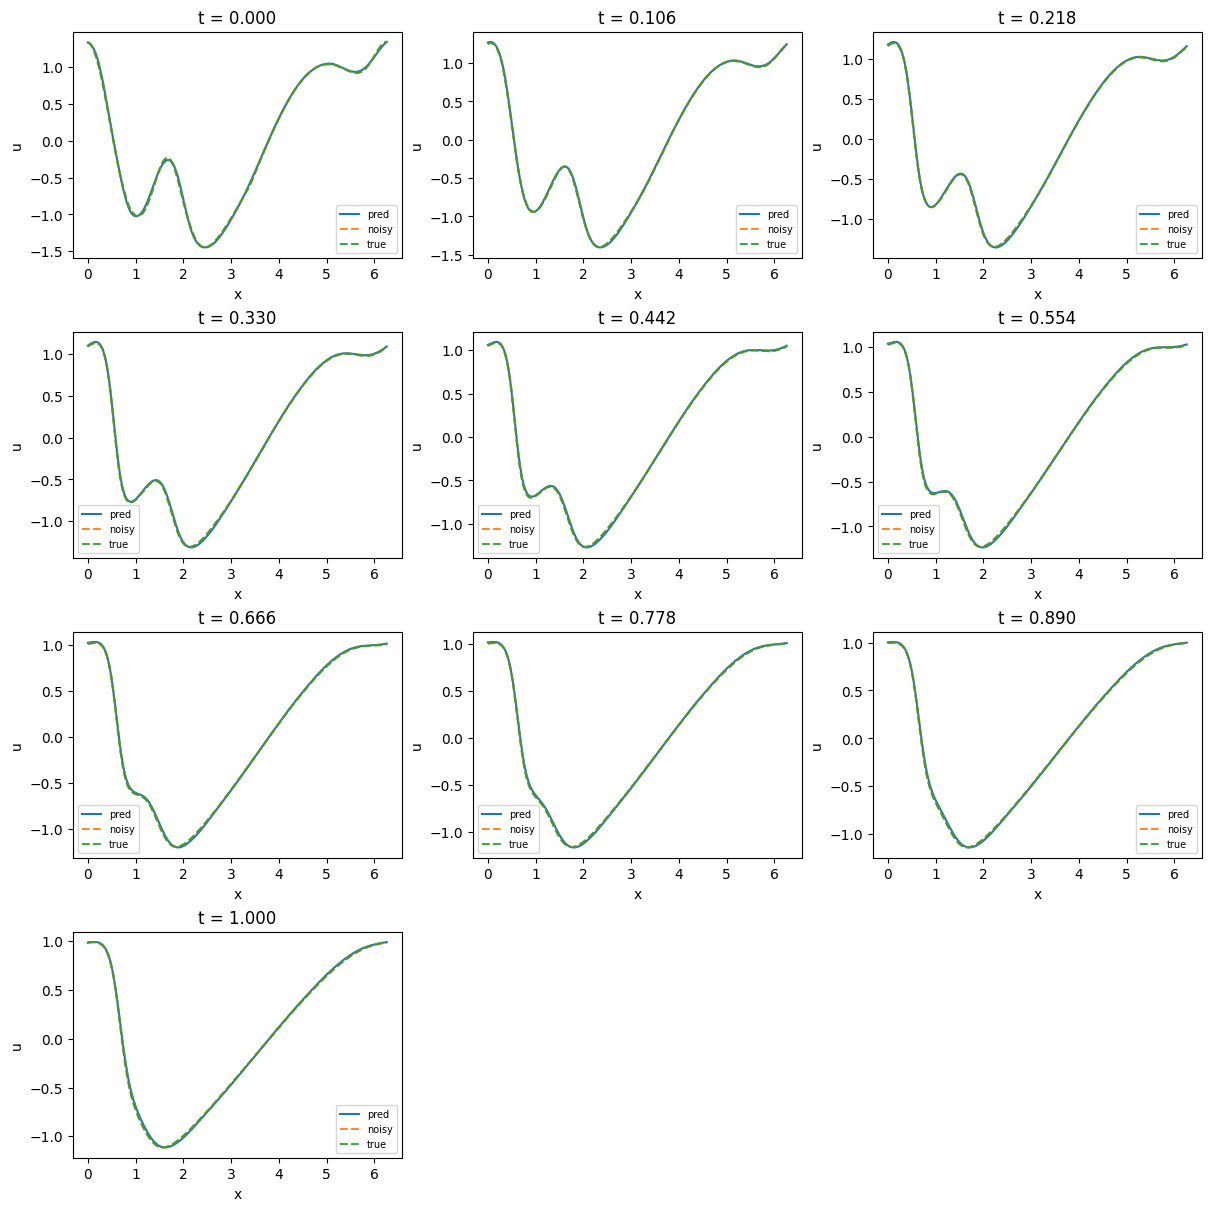

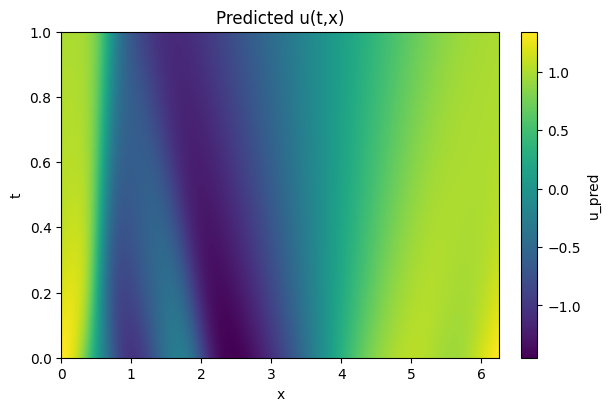

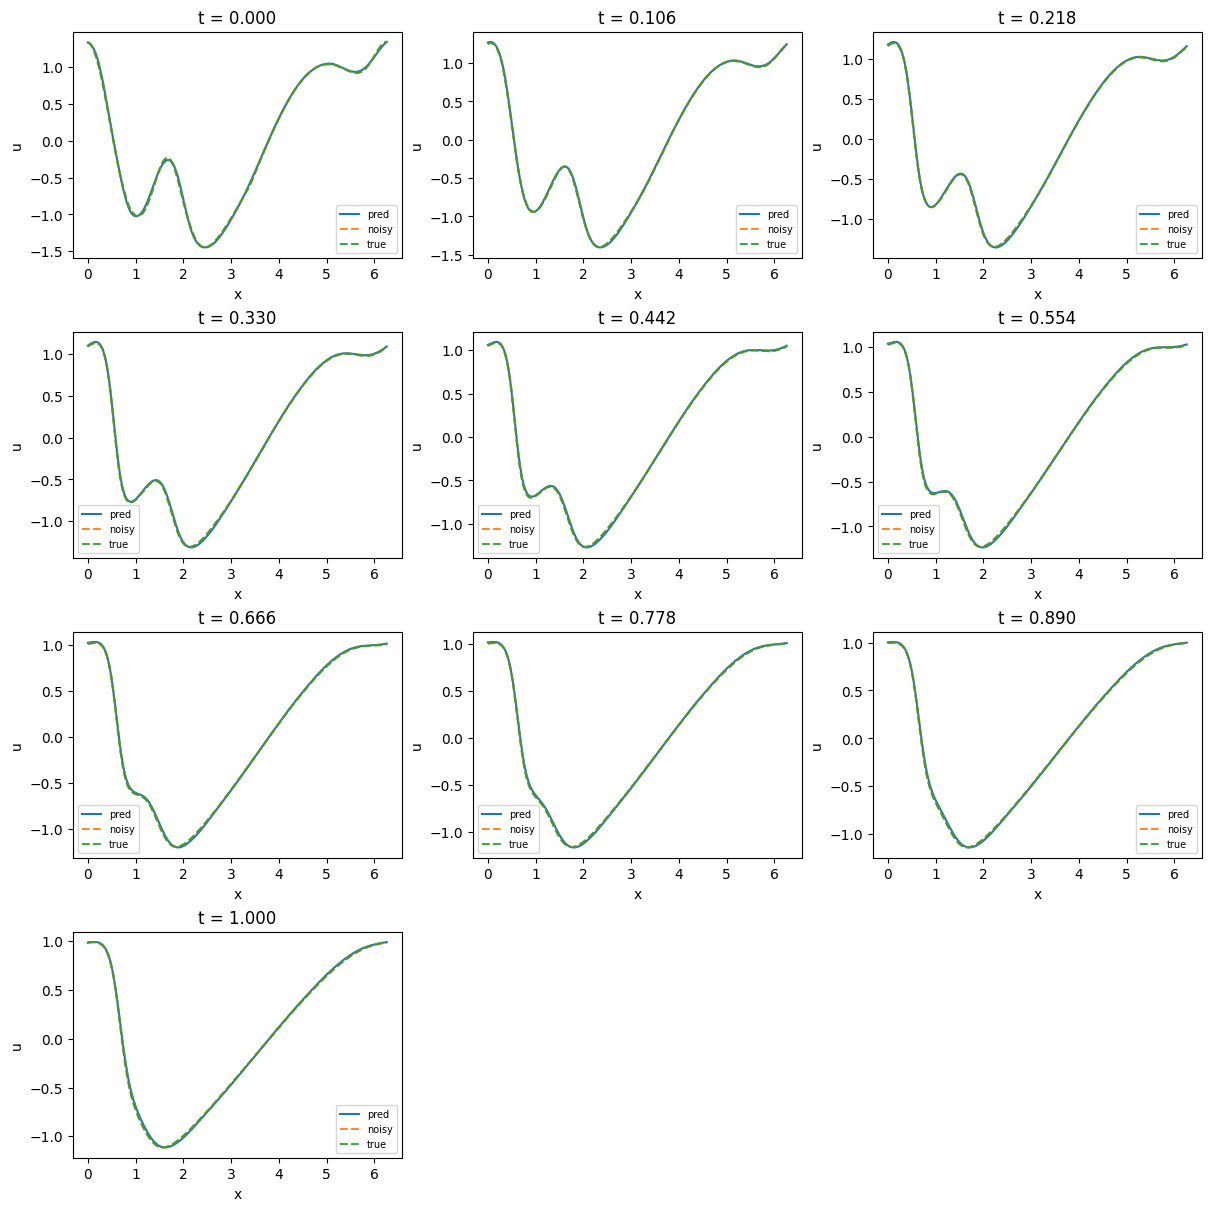

In [62]:
snapshot_comp(trainer_nl.u, stride_x, stride_t, y_noisy_np, y_np, t_np, x_np, snap_no=10)[0]

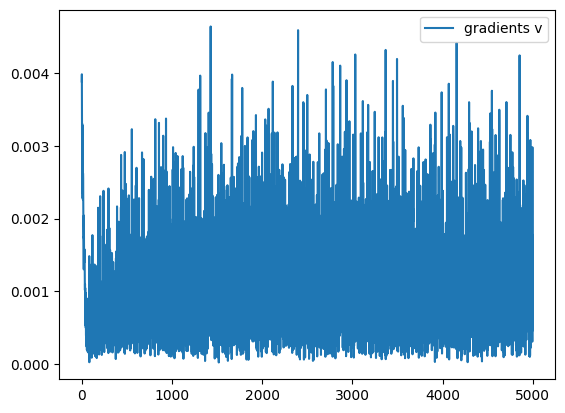

In [ ]:
#plt.plot(torch.arange(0, included), torch.tensor(gu).view(included, -1).mean(dim=1)[:included], label='gradients u')
plt.plot(torch.arange(0, included), torch.tensor(gv).view(included, -1).mean(dim=1)[:included], label='gradients v')
plt.legend(loc='best')

Prediction-truth error for our Current (joint) model: 

SimpleMLP model creates best fits for given data (for 0 noise). 'pred truth data' and 'data' are interchangeable when 0 noise. If we are to hope for a 'smooth enough' solution then we should only hope to push 'data' to zero for no noise level, otherwise the prediction provided by SimpleMLP is determined by a 'best fit' of the noisy data. Further study is required to understand how this 'best fit' is selected according to the loss function, specifically the loss of the current residual induced by the prediction given by SimpleMLP. Recall that 'current induced residual' is an indication of the residual for the current pred with differentiation by t (by autodiff) and the current predicted operator (symMLP). 'pred truth data' is useful for noisy situations as 'data' compares pred error to the given noisy data. 